# Introduction to Neural Networks - Lab

## Introduction

In this lab, you'll practice everything you have learned during the lecture. We know there is quite a bit of math involved, but don't worry! Using Python and trying things out yourself will actually make a lot of things much more clear! Before we start, let's load some necessary libraries so we can import our data.

## Objectives

In this lab you will:

- Import images using Keras 
- Build a "shallow" neural network from scratch 

As usual, we'll start by importing the necessary packages that we'll use in this lab. 

In [1]:
!pip install pillow

In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os

Using TensorFlow backend.


In this lab, you'll import a bunch of images to correctly classify them as "Santa", meaning that Santa is present on the image or "not Santa" meaning that something else is in the images. 

If you have a look at this GitHub repository, you'll notice that the images are simply stored in `.jpeg` files and stored under the folder `'/data'`. Luckily, `keras` has great modules that make importing images stored in this type of format easy. We'll do this for you in the cell below.

The images in the `'/data'` folder have various resolutions. We will reshape them so they are all 64 x 64 pixels.

In [3]:
# Directory path
train_data_dir = 'data/train'
test_data_dir = 'data/validation'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=132)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=790)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 132 images belonging to 2 classes.
Found 790 images belonging to 2 classes.


## Inspect and prepare data

## Look at some images

Note that we have four numpy arrays now: `train_images`, `train_labels`, `test_images`, and `test_labels`. We'll need to make some changes to the data in order to work with them, but before we do anything else, let's have a look at some of the images we loaded in `train_images`. You can use `array_to_img()` from `keras.processing.image` on any image (select any `train_image` using `train_image[index]` to look at it). 

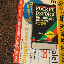

In [4]:
# Preview an image
array_to_img(train_images[10])

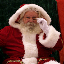

In [5]:
# Preview another image
array_to_img(train_images[130])

## The shape of data

Now, let's use `np.shape()` to look at what these numpy arrays look like.

In [6]:
# Preview the shape of both the images and labels for both the train and test sets (4 objects total)
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(790, 64, 64, 3)
(790, 2)
(132, 64, 64, 3)
(132, 2)


##  `train_images` and `test_images`

Let's start with `train_images`. From the lesson, you might remember that the expected input shape is $n$ x $l$. How does this relate to what we see here?

$l$ denotes the number of observations, or the number of images. The number of images in `train_images` is 790. $n$ is the number of elements in the feature vector for each image, or put differently, $n$ is the number of rows when unrowing the 3 (RGB) 64 x 64 matrices. 

So, translated to this example, we need to transform our `(790, 64, 64, 3)` matrix to a `(64*64*3, 790)` matrix! 


> Hint: You should use both the `.reshape()` method and then transpose the result using `.T`.

In [7]:
# Reshape the train images 
train_img_unrow = train_images.reshape(790, -1).T

Verify that the shape of the the newly created `train_img_unrow` is correct.

In [8]:
# Preview the shape of train_img_unrow
np.shape(train_img_unrow)

(12288, 790)

Next, let's transform `test_images` in a similar way. Note that the dimensions are different here! Where we needed to have a matrix shape of $n$ x $l$ for `train_images`; for `test_images`, we need to get to a shape of $n$ x $m$. What is $m$ here?

In [9]:
# Define appropriate m 
m = 132
test_img_unrow = test_images.reshape(m, -1).T

In [10]:
# Preview the shape of test_img_unrow
np.shape(test_img_unrow)

(12288, 132)

## `train_labels` and `test_labels`

Earlier, you noticed that `train_labels` and `test_labels` have shapes of $(790, 2)$ and $(132, 2)$ respectively. In the lesson, we expected $1$ x $l$ and $1$ x $m$.

Let's have a closer look.

In [11]:
# Run this cell; no need to edit
train_labels 

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Looking at this, it's clear that for each observation (or image), `train_labels` doesn't simply have an output of 1 or 0, but a pair - either `[0, 1]` or `[1, 0]`.

Having this information, we still don't know which pair corresponds with `santa` versus `not_santa`. Luckily, this was stored using `keras.preprocessing_image`, and you can get more info using the command `train_generator.class_indices`.

In [12]:
# Run this cell; no need to edit
train_generator.class_indices 

{'not_santa': 0, 'santa': 1}

Index 0 (the first column) represents `not_santa`, index 1 represents `santa`. Select one of the two columns and transpose the result such that you get $1$ x $l$ and $1$ x $m$ vectors respectively, and value `1` represents `santa`. 

In [13]:
# Your code here
train_labels_final = train_labels.T[[1]]

In [14]:
# Run this cell; no need to edit
np.shape(train_labels_final) 

(1, 790)

In [15]:
# Your code here
test_labels_final = test_labels.T[[1]]

In [16]:
# Run this cell; no need to edit
np.shape(test_labels_final) 

(1, 132)

As a final sanity check, look at an image and the corresponding label, so we're sure that santa is indeed stored as 1.

- First, use `array_to_image()` again on the original `train_images` with index 240 to look at this particular image 
- Use `train_labels_final` to get the 240th label 

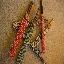

In [17]:
# Preview train image at index 240
array_to_img(train_images[240])

In [18]:
# Preview train label at index 240
train_labels_final[:,240]

array([0.], dtype=float32)

This seems to be correct! Feel free to try out other indices as well.

## Standardize the data

Remember that each RGB pixel in an image takes a value between 0 and 255. In Deep Learning, it is very common to standardize and/or center your dataset. For images, a common thing that is done is to make sure each pixel value is between 0 and 1. This can be done by dividing the entire matrix by 255. Do this here for the `train_img_unrow` and `test_img_unrow`. 

In [19]:
# Your code here 
train_img_final = train_img_unrow/255
test_img_final = test_img_unrow/255

type(test_img_unrow)

numpy.ndarray

## Build a logistic regression-based neural network

## Math recap

Now we can go ahead and build our own basic logistic regression-based neural network to distinguish images with Santa from images without Santa. You saw in the lesson that logistic regression can actually be represented as a very simple neural network.

Remember that we defined that, for each $x^{(i)}$:


$$ \mathcal{L}(\hat y ^{(i)}, y^{(i)}) =  - \big( y^{(i)} \log(\hat y^{(i)}) + (1-y^{(i)} )  \log(1-\hat y^{(i)})\big)$$

$$\hat{y}^{(i)} = \sigma(z^{(i)}) = \frac{1}{1 + e^{-(z^{(i)})}}$$ 

$$z^{(i)} = w^T x^{(i)} + b$$

The cost function is then given by:
$$J(w,b) = \dfrac{1}{l}\displaystyle\sum^l_{i=1}\mathcal{L}(\hat y^{(i)}, y^{(i)})$$

In the remainder of this lab, you'll do the following:

   - Initialize the parameters of the model
   - Perform forward propagation, and calculate the current loss
   - Perform backward propagation (which is basically calculating the current gradient)
   - Update the parameters (gradient descent)

## Parameter initialization

$w$ and $b$ are the unknown parameters to start with: 
- remember that $b$ is a scalar
- $w$ however, is a vector of shape $n$ x $1$, with $n$ being `horizontal_pixel x vertical_pixel x 3`

## Initialize $b$

 Initialize $b$ as a scalar with value 0.

In [20]:
# Your code here
b = 0

## Initialize $w$

Define a function `init_w()`, with a parameter `n`. The function should return an array with zeros that has a shape $n$ x $1$.

In [21]:
# Define your function
def init_w(n):
    w = np.zeros((n, 1))
    return w

In [22]:
# Call your function using appropriate parameters
w = init_w(64*64*3)

## Forward propagation

In forward propagation, you:
- get `x`
- compute `y_hat`: 

$$ (\hat y^{(1)}, \hat y^{(2)}, \ldots , \hat y^{(l)})= \sigma(w^T x + b) = \Biggr(\dfrac{1}{1+exp(w^T x^{(1)}+ b)},\ldots, \dfrac{1}{1+exp(w^T x^{(l)}+ b)}\Biggr) $$
- You calculate the `cost` function: $J(w,b) = -\dfrac{1}{l}\displaystyle\sum_{i=1}^{l}y^{(i)}\log(\hat y^{(i)})+(1-y^{(i)})\log(1-\hat y^{(i)})$

Here are the two formulas you will be using to compute the gradients. Don't be scared by the mathematics. The long formulas are just to show that this corresponds with what we derived in the lesson!

$$ \frac{dJ(w,b)}{dw} = \displaystyle\frac{1}{l}\displaystyle\sum^l_{i=1} \frac{d\mathcal{L}(\hat y^{(i)}, y^{(i)})}{dw}= \displaystyle\frac{1}{l}\displaystyle\sum^l_{i=1} x^{(i)} dz^{(i)}  = \displaystyle\frac{1}{l}\displaystyle\sum^l_{i=1} x^{(i)}(\hat y^{(i)}-y^{(i)})  = \frac{1}{l}x(\hat y-y)^T$$

$$ \frac{dJ(w,b)}{db} = \displaystyle\frac{1}{l}\displaystyle\sum^l_{i=1} \frac{d\mathcal{L}(\hat y^{(i)}, y^{(i)})}{db}= \displaystyle\frac{1}{l}\displaystyle\sum^l_{i=1} dz^{(i)}  = \displaystyle\frac{1}{l}\displaystyle\sum^l_{i=1} (\hat y^{(i)}-y^{(i)})$$

In [23]:
# Define the propagation function
def propagation(w, b, x, y):
    l = x.shape[1]
    y_hat = 1/(1 + np.exp(- (np.dot(w.T, x) + b)))                                  
    cost = -(1/l) * np.sum(y * np.log(y_hat) + (1-y)* np.log(1 - y_hat))    
    dw = (1/l) * np.dot(x,(y_hat - y).T)
    db = (1/l) * np.sum(y_hat - y)
    return dw, db, cost

In [24]:
# Use the propogation function
dw, db, cost = propagation(w, b, train_img_final, train_labels_final)

In [25]:
print(dw)

print(db)

print(cost)

[[-0.05781583]
 [-0.05435592]
 [-0.06370812]
 ...
 [-0.07490941]
 [-0.06691735]
 [-0.07259121]]
-0.01139240506329114
0.6931471805599452


## Optimization

Next, in the optimization step, we have to update $w$ and $b$ as follows:

$$w := w - \alpha * dw$$
$$b := b - \alpha * db$$

Note that this `optimization()` function uses the `propagation()` function. It loops over the `propagation()` function in each iteration, and updates both $w$ and $b$ right after that! 

In [26]:
# Complete the function below using your propagation function to define dw, db and cost 
# Then use the formula above to update w and b in the optimization function 
def optimization(w, b, x, y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        dw, db, cost = propagation(w, b, x, y)    
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs and print them every 50 iterations
        if i % 50 == 0:
            costs.append(cost)
        if print_cost and i % 50 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    return w, b, costs

In [27]:
# Run this block of code as is
w, b, costs = optimization(w, b, train_img_final, train_labels_final, 
                           num_iterations= 151, learning_rate = 0.0001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 50: 0.675046
Cost after iteration 100: 0.668483
Cost after iteration 150: 0.662210


## Make label predictions: Santa or not?

Next, let's create a function that makes label predictions. We'll later use this when we will look at our Santa pictures. What we want is a label that is equal to 1 when the predicted $y$ is bigger than 0.5, and 0 otherwise. 

In [29]:
def prediction(w, b, x):
    l = x.shape[1]
    y_prediction = np.zeros((1, l))
    w = w.reshape(x.shape[0], 1)
    y_hat = 1/(1 + np.exp(- (np.dot(w.T, x) + b))) 
    p = y_hat
    
    for i in range(y_hat.shape[1]):
        # Transform the probability into a binary classification using 0.5 as the cutoff
        if (y_hat[0,i] > 0.5): 
            y_prediction[0, i] = 1
        else:
            y_prediction[0, i] = 0
    return y_prediction

Let's try this out on a small example. Make sure you have 4 predictions in your output here!

In [30]:
# Run this block of code as is
w = np.array([[0.035], [0.123], [0.217]])
b = 0.2
x = np.array([[0.2, 0.4, -1.2, -2], 
              [1, -2., 0.1, -1], 
              [0.2, 0.4, -1.2, -2]])

prediction(w, b, x)

array([[1., 1., 0., 0.]])

## The overall model

Now, let's build the overall model!

In [31]:
# Review this code carefully
def model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    b = 0
    w = init_w(np.shape(x_train)[0]) 

    # Gradient descent (≈ 1 line of code)
    w, b, costs = optimization(w, b, x_train, y_train, num_iterations, learning_rate, print_cost)
    
    y_pred_test = prediction(w, b, x_test)
    y_pred_train = prediction(w, b, x_train)

    # Print train/test errors
    print('train accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    output = {'costs': costs, 
              'y_pred_test': y_pred_test,  
              'y_pred_train' : y_pred_train,  
              'w' : w, 
              'b' : b, 
              'learning_rate' : learning_rate, 
              'num_iterations': num_iterations}
    
    return output

In [34]:
# Run the model!
# ⏰ Expect your code to take several minutes to run
output = model(train_img_final, train_labels_final, test_img_final, test_labels_final,
               num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 50: 0.881778
Cost after iteration 100: 0.765854
Cost after iteration 150: 0.632392
Cost after iteration 200: 0.522419
Cost after iteration 250: 0.446686
Cost after iteration 300: 0.395508
Cost after iteration 350: 0.358566
Cost after iteration 400: 0.330120
Cost after iteration 450: 0.307578
Cost after iteration 500: 0.290297
Cost after iteration 550: 0.278666
Cost after iteration 600: 0.270862
Cost after iteration 650: 0.264081
Cost after iteration 700: 0.257715
Cost after iteration 750: 0.251698
Cost after iteration 800: 0.245994
Cost after iteration 850: 0.240571
Cost after iteration 900: 0.235405
Cost after iteration 950: 0.230474
Cost after iteration 1000: 0.225760
Cost after iteration 1050: 0.221247
Cost after iteration 1100: 0.216919
Cost after iteration 1150: 0.212764
Cost after iteration 1200: 0.208772
Cost after iteration 1250: 0.204930
Cost after iteration 1300: 0.201230
Cost after iteration 1350: 0.197664
Cost after iter

## Summary

Well done! In this lab you built your first neural network in order to identify images of Santa! In the upcoming labs you'll see how to extend your neural networks to include a larger number of layers and how to then successively prune these complex schemas to improve test and train accuracies.